In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import h5py
import os

from analysis import plot, utils, process # importing analysis module enables import from model folder

%matplotlib inline

TRIAL_NAME = "long_rand"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

pop_color = plot.pop_color
pop_names = plot.pop_names

savefig = True

In [2]:
stim_type, paths, stim_info, config_hp = utils.get_trial_info(TRIAL_PATH)
stimulus_type, isbaseline, isstandard = stim_type
INPUT_PATH, NODE_FILES, SPIKE_FILE = paths
t_stop, stim_setting, stim_params = stim_info

if isbaseline:
    stim_params = stim_setting['short']
t_start = stim_params['t_start']
on_time, off_time = stim_params['on_time'], stim_params['off_time']

### Load data

In [3]:
elec_id = 0
lfps = utils.load_ecp_to_xarray(os.path.join(TRIAL_PATH, 'ecp.h5'))
n_channel = lfps.channel_id.size
lfp = lfps.sel(channel_id=elec_id)
# display(lfps)

In [4]:
with h5py.File(os.path.join(TRIAL_PATH, 'spike_rate.h5'), 'r') as f:
    pop_rspk = xr.DataArray(
        np.stack([g['data'] for g in f['populations'].values()], axis=0),
        coords = dict(
            population = list(f['populations'].keys()),
            time = np.arange(*f['time'])
        ),
        attrs = dict(
            fs = 1000 / f['time'][2]
        )
    ).to_dataset(name='spike_number', promote_attrs=True)
    pop_rspk.update(dict(
        population_number = xr.DataArray(
            [g.attrs['number'] for g in f['populations'].values()],
            coords = dict(
                population = pop_rspk.coords['population']
            )
        )
    ))
# display(pop_rspk)

In [5]:
spike_groups = [['CP', 'CS'], ['FSI'], ['LTS']]
# group_label = [' + '.join(spk_grp) for spk_grp in spike_groups]
group_label = ['PN', 'FSI', 'LTS']
group_color = [pop_color[spk_grp[0]] for spk_grp in spike_groups]

group_rspk = xr.concat([pop_rspk.sel(population=grp).sum(dim='population', keep_attrs=True)
                        for grp in spike_groups], dim=pd.Index(group_label, name='population'))
spike_rate = group_rspk.fs / group_rspk.population_number * group_rspk.spike_number
spike_rate_std = spike_rate.std(dim='time')
idx = spike_rate_std.values > 0
spike_rate_norm = spike_rate - spike_rate.mean(dim='time')
spike_rate_norm[idx] /= spike_rate_std[idx]
group_rspk.update(dict(
    spike_rate = spike_rate,
    spike_rate_norm = spike_rate_norm,
    spike_rate_std = spike_rate_std
))
# display(group_rspk)

<xarray.Dataset>
Dimensions:            (time: 5800, population: 3)
Coordinates:
  * time               (time) float64 0.0 2.5 5.0 ... 1.45e+04 1.45e+04
  * population         (population) object 'PN' 'FSI' 'LTS'
Data variables:
    spike_number       (population, time) int64 0 0 18 21 20 ... 13 18 11 10 6
    population_number  (population) int64 8000 1200 800
    spike_rate         (population, time) float64 0.0 0.0 0.9 ... 5.5 5.0 3.0
    spike_rate_norm    (population, time) float64 -3.399 -3.399 ... -0.836
    spike_rate_std     (population) float64 0.608 5.136 9.12
Attributes:
    fs:       400.0

### Calculate PSD

In [6]:
tseg = 0.5  # time segment length for PSD

if isbaseline:
    on_time, off_time = on_time + off_time, 0.0
else:
#     # if any correction needed
#     t_start = 1.25  # sec. Time to start burst input
#     on_time = 0.75  # sec. Burst input duration
#     off_time = 0.75  # sec. Silence duration
    windows = process.get_stim_windows(on_time, off_time, t_start,
                                       lfps.time[-1] / 1000)

In [7]:
f, pxx, lfp_stim_cycle = process.get_psd_on_stimulus(
    lfps, lfps.fs, on_time, off_time, t_start, t=lfps.time, tseg=tseg)
psd_lfp = xr.DataArray(pxx, coords={'channel': lfps.channel_id.values, 'frequency': f})

psd_rspk = []
valid_grp = []
for grp in group_label:
    rspk = group_rspk.sel(population=grp)
    if rspk.spike_rate_std > 0:
        f, pxx, rspk_stim_cycle = process.get_psd_on_stimulus(
            rspk.spike_rate_norm, rspk.fs, on_time, off_time, t_start, t=rspk.time, tseg=tseg)
        psd_rspk.append(pxx)
        valid_grp.append(grp)
psd_rspk = xr.DataArray(np.array(psd_rspk), coords={'population': valid_grp, 'frequency': f})

### Plot traces

#### LFP

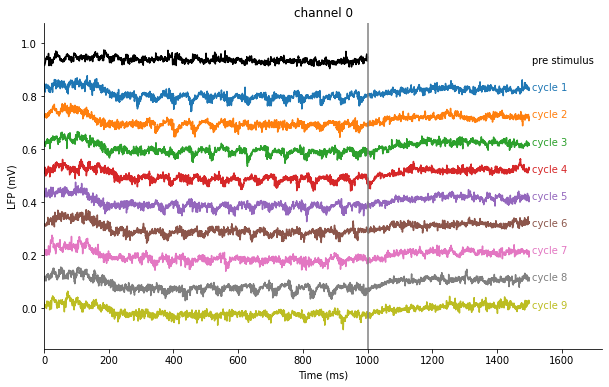

In [8]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
plot.plot_stimulus_cycles(lfp.time, lfp.values, lfp_stim_cycle, dv_n_sigma=5., var_label='LFP (mV)', ax=ax)
plt.title('channel %d' % lfp.channel_id)
plt.show()

#### Spike time histogram

In [9]:
figsize = (10, 5)
pad = 1.5
var_label = 'Firing Rate (Hz)'
clr = None
demean = False

if savefig:
    figsize = (6, 2)
    # pad = (0.5, 0.3) # short_rand
    pad = (0.4, 0.6) # long_rand
    var_label = 'Firing rate'
    clr =  group_color
    demean = True
    rspk_stim_cycle.update(n_cycle=3)

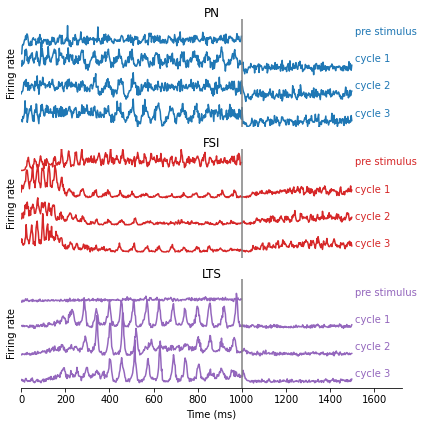

In [11]:
fig, axs = plt.subplots(len(spike_groups), 1, figsize=(figsize[0], figsize[1] * len(spike_groups)))
for i, ax in enumerate(axs):
    rspk = group_rspk.spike_rate.isel(population=i)
    plot.plot_stimulus_cycles(rspk.time, rspk.values, rspk_stim_cycle, dv_n_sigma=5.,
                              pad=pad, color=clr[i], demean=demean, var_label=var_label, ax=ax)
    ax.set_title(rspk.population.item())
    ax.set_xlabel('')
axs[-1].set_xlabel('Time (ms)')

if savefig:  # need run twice due to a bug not setting ylim correctly
    for ax in axs:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_title(ax.get_title(), y=0.96)
    for ax in axs[:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])

    plt.tight_layout()
    # plot.savefig(fig, 'Fig2_C1') # short_rand
    plot.savefig(fig, 'Fig2_C2') # long_rand

plt.tight_layout()
plt.show()

### PSD of LFP

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 4 - 600 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -4.5871, 1.1604                                          
                                                                                                  
                                       9 peaks were found:                                        
          

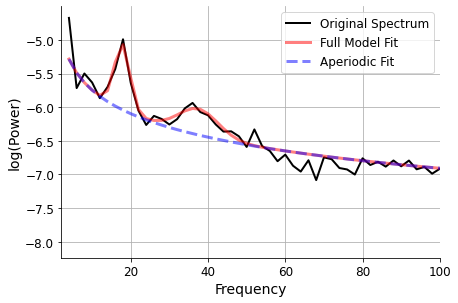

In [11]:
fooof_params = dict(aperiodic_mode='fixed', freq_range=600., peak_width_limits=100.)
plt_range = [2., 100.]
plt_log = False
plt_db = True
figsize = (6, 4)

if n_channel <= 1:
    results = plot.fit_fooof(psd_lfp.frequency.values, psd_lfp.sel(channel=elec_id), **fooof_params,
                             report=True, plot=True, plt_log=plt_log, plt_range=plt_range, figsize=figsize)
else:
    results, _, _ = plot.plot_channel_psd(psd_lfp, channel_id=elec_id, **fooof_params,
                                          plt_log=plt_log, plt_range=plt_range, figsize=figsize)
plt.show()
results, fm = results

save_fooof = False
if save_fooof:
    SAVE_PATH = os.path.join(TRIAL_PATH, 'FOOOF_results')
    fm.save(SAVE_PATH, save_results=True, save_settings=True, save_data=True)

    # Save out a report of the current model fit & results
    REPORT_PATH = os.path.join(TRIAL_PATH, 'FOOOF_report')
    fm.save_report(REPORT_PATH, plt_log=plt_log)

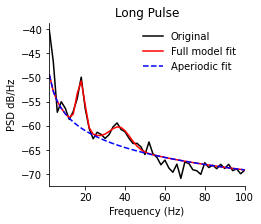

In [12]:
if savefig:
    fig, ax = plt.subplots(figsize=(3.5, 3))
    _ = plot.plot_fooof(psd_lfp.frequency.values, psd_lfp.sel(channel=elec_id),
                            results, plt_log=False, plt_range=plt_range, plt_db=plt_db, ax=ax)
    ax.legend(frameon=False)
    
    # ax.set_title('Baseline')
    # ax.set_title('Short Pulse')
    ax.set_title('Long Pulse')

    # plot.savefig(fig, 'Fig1_E2') # baseline
    # plot.savefig(fig, 'Fig2_D1A') # short_rand
    plot.savefig(fig, 'Fig2_D1B') # long_rand

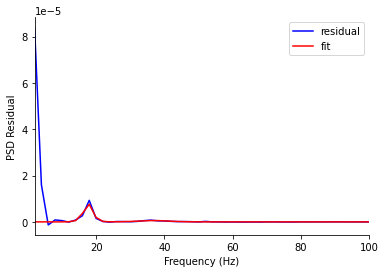

In [13]:
_, ax = plt.subplots(1, 1, figsize=figsize)
_ = plot.psd_residual(psd_lfp.frequency.values, psd_lfp.sel(channel=elec_id).values,
                      results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
yl = plt.gca().get_ylim()
plt.gca().set_ylim(bottom=max(yl[0], -yl[1]))
plt.show()

#### Scalogram

In [14]:
tres = 0.004 # sec. time resolution (0.005 at most for 200 Hz sampling rate)
use_cwt = True
axis = lfps.dims.index('time')

if use_cwt:
    # Use wavelet
    lfp_sxx = plot.cwt_spectrogram_xarray(lfps, lfps.fs, axis=axis, downsample_fs=1 / tres,
                                          channel_coords={'channel_id': lfps.channel_id}, freq_range=(1 / tseg, np.inf))
else:
    # Use spectrogram
    lfp_sxx = plot.spectrogram_xarray(lfps, lfps.fs, tseg, axis=axis, tres=np.inf,
                                      channel_coords={'channel_id': lfps.channel_id})

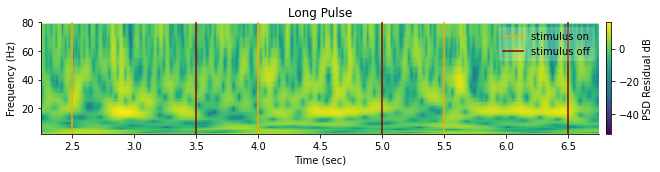

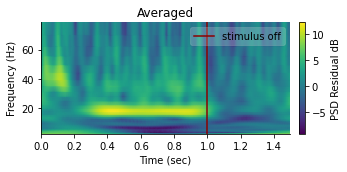

In [15]:
remove_aperiodic = fooof_params
log_power = 'dB'
sxx_plt_range = plt_range
clr_freq_range = None
figsize = (10, 5)

if savefig:
    figsize = (10, 2.5)
    sxx_plt_range = [2.0, 80.0]

fig1, axs1 = plt.subplots(n_channel, 1, figsize=(figsize[0], figsize[1] * n_channel), squeeze=False)
for i, ax in enumerate(axs1.ravel()):
    sxx = lfp_sxx.isel(channel_id=i).drop('cone_of_influence_frequency')
    if remove_aperiodic is None:
        fooof_results = None
    else:
        sxx_tot = sxx.PSD.mean(dim='time')
        fooof_results, _ = plot.fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **remove_aperiodic)
    _ = plot.plot_spectrogram(sxx, remove_aperiodic=fooof_results, log_power=log_power,
                              plt_range=sxx_plt_range, clr_freq_range=clr_freq_range, pad=0.01, ax=ax)
    
    ax.set_title(f'channel {sxx.channel_id.item():d}')
    if not isbaseline:
        if not savefig:
            ax.axvline(t_start, color='gray', label='pre stimulus')
        for j, win in enumerate(windows):
            labels = [None, None] if j else ['stimulus on', 'stimulus off']
            ax.axvline(win[0], color='orange', label=labels[0])
            ax.axvline(win[1], color='darkred', label=labels[1])
    ax.legend(loc='upper right', framealpha=0.2)
plt.tight_layout()

if savefig:
    figsize = (5, 2.5)

if not isbaseline:
    cyc_wins = process.get_stim_windows(on_time, off_time, t_start,
                                       lfps.time[-1] / 1000, win_extend=off_time)
    _, _, lfp_sxx_avg = process.get_windowed_data(lfp_sxx.PSD, cyc_wins, {0: np.arange(cyc_wins.shape[0])})
    lfp_sxx_avg = lfp_sxx_avg[0].mean_.sel(unique_cycle=0).to_dataset(name='PSD')

    fig2, axs2 = plt.subplots(n_channel, 1, figsize=(figsize[0], figsize[1] * n_channel), squeeze=False)
    for i, ax in enumerate(axs2.ravel()):
        sxx = lfp_sxx_avg.isel(channel_id=i)
        if remove_aperiodic is None:
            fooof_results = None
        else:
            sxx_tot = sxx.PSD.mean(dim='time')
            fooof_results, _ = plot.fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **remove_aperiodic)
        _ = plot.plot_spectrogram(sxx, remove_aperiodic=fooof_results, log_power=log_power,
                                  plt_range=sxx_plt_range, clr_freq_range=clr_freq_range, pad=0.03, ax=ax)
        ax.set_title(f'channel {sxx.channel_id.item():d}' + ' averaged over cycles')
        ax.axvline(on_time, color='darkred', label='stimulus off')
        ax.legend(loc='upper right', framealpha=0.2)
    plt.tight_layout()

if savefig:
    if not isbaseline:
        for ax in axs2.ravel():
            ax.set_title('Averaged')

    n_cycle = 3
    start_cycle = 1
    t_cycle = on_time + off_time
    xl = [t_start + start_cycle * t_cycle - 0.5 * off_time, t_start + (start_cycle + n_cycle) * t_cycle - 0.5 * off_time]
    for ax in axs1.ravel():
        ax.set_xlim(xl)
        ax.set_ylim(top=80.)

        # ax.set_title('Short Pulse')
        ax.set_title('Long Pulse')

    # plot.savefig(fig1, 'Fig2_D2A') # short_rand
    # plot.savefig(fig2, 'Fig2_D3A') # short_rand
    plot.savefig(fig1, 'Fig2_D2B') # long_rand
    plot.savefig(fig2, 'Fig2_D3B') # long_rand

plt.show()

### PSD of spike time histogram

In [16]:
axis = group_rspk.spike_rate_norm.dims.index('time')

if use_cwt:
    # Use wavelet
    rspk_sxx = plot.cwt_spectrogram_xarray(
        group_rspk.spike_rate_norm.sel(population=valid_grp), group_rspk.fs, axis = axis, downsample_fs=1 / tres,
        channel_coords={'population': valid_grp}, freq_range=(1 / tseg, np.inf))
else:
    # Use spectrogram
    rspk_sxx = plot.spectrogram_xarray(
        group_rspk.spike_rate_norm.sel(population=valid_grp), group_rspk.fs, tseg,
        axis=axis, tres=np.inf, channel_coords={'population': valid_grp})

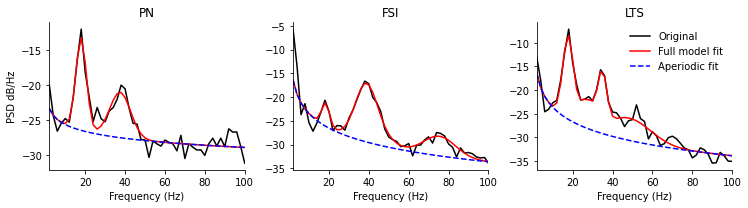

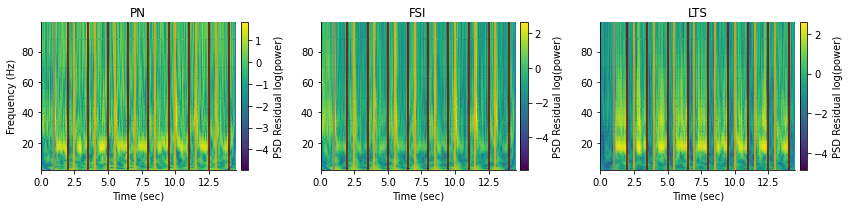

In [17]:
remove_aperiodic = fooof_params
log_power = True
clr_freq_range = None
down_fs = 40.  # Hz. downsample frequency
plot_residual = False

ngrps = psd_rspk.population.size
fig1, axs1 = plt.subplots(1, ngrps, figsize=(3.5 * ngrps, 3))
fig2, axs2 = plt.subplots(1, ngrps, figsize=(4 * ngrps, 3))

for i, grp in enumerate(valid_grp):
    ax = axs1[i]
    psd = psd_rspk.sel(population=grp)
    spk_results, _ = plot.fit_fooof(f, psd, **fooof_params, report=False, plot=False)
    if plot_residual:
        _ = plot.psd_residual(psd.frequency.values, psd.values,
                              spk_results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
        yl = ax.get_ylim()
        ax.set_ylim(bottom=max(yl[0], -yl[1]))
    else:
        _ = plot.plot_fooof(psd.frequency.values, psd.values,
                            spk_results, plt_log=plt_log, plt_range=plt_range, plt_db=plt_db, ax=ax)
    if i:
        ax.set_ylabel(None)
    if i != ngrps - 1:
        ax.get_legend().remove()
    ax.set_title(grp)

    ax = axs2[i]
    sxx = rspk_sxx.sel(population=grp)
    if remove_aperiodic is None:
        fooof_results = None
    else:
        sxx_tot = sxx.PSD.mean(dim='time')
        fooof_results, _ = plot.fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **remove_aperiodic)
    _ = plot.plot_spectrogram(sxx, remove_aperiodic=fooof_results, log_power=log_power, plt_range=plt_range,
                              clr_freq_range=clr_freq_range, ax=ax)
    ax.set_title(grp)
    if not isbaseline:
        for j, win in enumerate(windows):
            labels = [None, None] if j else ['stimulus on', 'stimulus off']
            ax.axvline(win[0], color='orange', label=labels[0])
            ax.axvline(win[1], color='darkred', label=labels[1])
        ax.axvline(t_start, color='gray', label='pre stimulus')
    if i:
        ax.set_ylabel(None)
fig1.tight_layout()
fig2.tight_layout()
plt.show()

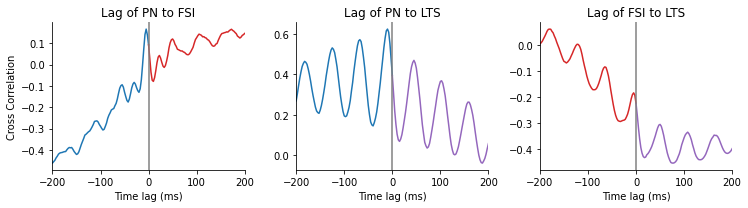

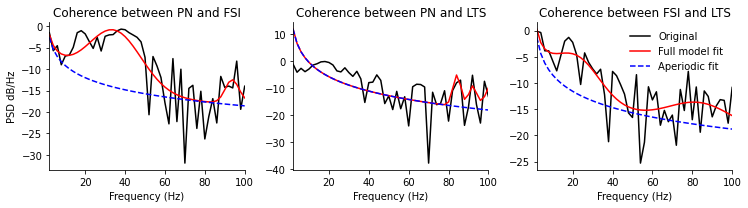

In [18]:
max_lag = 200. # ms
xcorr_color = True
grp_pairs = [[0, 1], [0, 2], [1, 2]]

dt = 1000 / group_rspk.fs
npairs = len(grp_pairs)

fig3, axs3 = plt.subplots(1, npairs, figsize=(3.5 * npairs, 3))
fig4, axs4 = plt.subplots(1, npairs, figsize=(3.5 * npairs, 3))

for i, grp_pair in enumerate(grp_pairs):
    rspk_pair = group_rspk.sel(population=[group_label[grp_pair[0]], group_label[grp_pair[1]]])
    if not rspk_pair.spike_rate_std.all():
        continue

    # cross-correlation
    ax = axs3[i]
    rspk_pair_win = rspk_pair.spike_rate_norm.sel(time=slice(t_start, None))
    if xcorr_color:
        idx0 = min(int(max_lag / dt), rspk_pair_win.time.size - 1)
        xcorr, xcorr_lags = plot.xcorr_coeff(*rspk_pair_win.values, dt=dt, max_lag=max_lag, plot=False)
        ax.plot(xcorr_lags[:idx0 + 1], xcorr[:idx0 + 1], color=group_color[grp_pair[0]])
        ax.plot(xcorr_lags[idx0:], xcorr[idx0:], color=group_color[grp_pair[1]])
        ax.axvline(0., color='gray')
        ax.set_xlim(xcorr_lags[[0, -1]])
        ax.set_ylabel('Cross Correlation')
    else:
        xcorr, xcorr_lags = plot.xcorr_coeff(*rspk_pair_win.values, dt=dt, max_lag=max_lag, ax=ax)
    ax.set_xlabel('Time lag (ms)')
    ax.set_title('Lag of %s to %s' % tuple(rspk_pair.population.values))
    if i:
        ax.set_ylabel(None)

    # coherence
    ax = axs4[i]
    f, cxy = process.get_coh_on_stimulus(*rspk_pair.spike_rate_norm, rspk_pair.fs, on_time, off_time,
                                      t_start, t=rspk_pair.time, tseg=tseg)
    idx = cxy > 0
    if not np.any(idx):
        continue
    # calculate residual
    fooof_results, _ = plot.fit_fooof(f[idx], cxy[idx], **fooof_params, report=False, plot=False)
    if plot_residual:
        _ = plot.psd_residual(f, cxy, fooof_results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
        yl = ax.get_ylim()
        ax.set_ylim(bottom=max(yl[0], -yl[1]))
    else:
        _ = plot.plot_fooof(f[idx], cxy[idx],
                            fooof_results, plt_log=plt_log, plt_range=plt_range, plt_db=plt_db, ax=ax)
    ax.set_title('Coherence between %s and %s' % tuple(rspk_pair.population.values))
    if i:
        ax.set_ylabel(None)
    if i != ngrps - 1:
        ax.get_legend().remove()
fig3.tight_layout()
fig4.tight_layout()
plt.show()

In [19]:
if savefig:
    # plot.savefig(fig1, 'Fig1_S1_A') # baseline
    # plot.savefig(fig4, 'Fig1_S1_B') # baseline

    # plot.savefig(fig1, 'Fig2_S1_A1') # short_rand
    # plot.savefig(fig4, 'Fig2_S1_B1') # short_rand

    plot.savefig(fig1, 'Fig2_S1_A2') # long_rand
    plot.savefig(fig4, 'Fig2_S1_B2') # long_rand